In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from pathlib import Path
import pandas as pd
import numpy as np

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame, Row, Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

import statsmodels.api as sm
import scipy.stats as stats

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from synapse.ml.lightgbm import *

pio.renderers.default = "iframe"

In [7]:
def fix_up_df(df: pd.DataFrame):
    log_transform = [
        "n_craters_in_study_region",
        "center_to_center_nearest_neighbor_distance_mean",
        "center_to_center_nearest_neighbor_distance_stdev",
        "center_to_center_nearest_neighbor_distance_min",
        "center_to_center_nearest_neighbor_distance_max",
        "rim_to_rim_nearest_neighbor_distance_mean",
        "rim_to_rim_nearest_neighbor_distance_stdev",
        "rim_to_rim_nearest_neighbor_distance_max",
    ]
    
    df["z"] = df.z.fillna(0)
    df["za"] = df.za.fillna(0)
    df["n_craters_removed"] = df.n_craters_added_in_study_region - df.n_craters_in_study_region
    return df

# def fix_up_df(df: pd.DataFrame):
#     df["z"] = df.z.fillna(0)
#     df["za"] = df.za.fillna(0)
#     df["percent_rim_to_rim_nearest_neighbors_zero"] = df.n_non_zero_rim_to_rim_nearest_neighbor_distances / df.n_craters_in_study_region
#     df["log_n_craters_added_in_study_region"] = np.log(df.n_craters_added_in_study_region)
#     df["craters_removed"] = df.n_craters_added_in_study_region - df.n_craters_in_study_region
#     df["log_craters_removed"] = np.log(1 + df.craters_removed)
#     for x in ivs:
#         df[f"log_{x}"] = np.log(1 + df[x])
#     return df

In [8]:
base_path = "/data/saturation/random_runs_20230812"

ivs = [
    "slope",
    # "effective_radius_multiplier",
    # "r_stat_multiplier",
    # "min_rim_percentage",
    # "z",
    "za",
    "n_craters_in_study_region",
    "areal_density",
    "areal_density_overlap_2",
    "areal_density_overlap_3",
    "center_to_center_nearest_neighbor_distance_mean",
    "center_to_center_nearest_neighbor_distance_stdev",
    "center_to_center_nearest_neighbor_distance_min",
    "center_to_center_nearest_neighbor_distance_max",
    "rim_to_rim_nearest_neighbor_distance_mean",
    "rim_to_rim_nearest_neighbor_distance_stdev",
    "rim_to_rim_nearest_neighbor_distance_max",
    # "log_rim_to_rim_nearest_neighbor_distance_mean",
    # "log_rim_to_rim_nearest_neighbor_distance_stdev",
    # "log_rim_to_rim_nearest_neighbor_distance_max",
    # "log_center_to_center_nearest_neighbor_distance_mean",
    # "log_center_to_center_nearest_neighbor_distance_stdev",
    # "log_center_to_center_nearest_neighbor_distance_max",
    # "log_n_craters_in_study_region",
]

non_constant_ivs = [
    "z",
    "za",
    "areal_density",
    "areal_density_overlap_2",
    "areal_density_overlap_3",
    "center_to_center_nearest_neighbor_distance_mean",
    "center_to_center_nearest_neighbor_distance_stdev",
    "center_to_center_nearest_neighbor_distance_min",
    "center_to_center_nearest_neighbor_distance_max",
    "rim_to_rim_nearest_neighbor_distance_mean",
    "rim_to_rim_nearest_neighbor_distance_stdev",
    "rim_to_rim_nearest_neighbor_distance_max",
]

In [9]:
sample_size = 50

train_df = pd.read_parquet(f"{base_path}/train_{sample_size}.parquet")
train_df = fix_up_df(train_df)

test_df = pd.read_parquet(f"{base_path}/test_{sample_size}.parquet")
test_df = fix_up_df(test_df)

metric = "n_craters_removed"

In [10]:
n_cores = 24

spark = SparkSession.builder \
                    .master(f"local[{n_cores}]") \
                    .appName("Saturation") \
                    .config("spark.driver.memory", "48g") \
                    .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.11.2") \
                    .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
                    .getOrCreate()
sc = spark.sparkContext

23/08/30 07:57:09 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.86.20 instead (on interface enp8s0)
23/08/30 07:57:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
https://mmlspark.azureedge.net/maven added as a remote repository with the name: repo-1
Ivy Default Cache set to: /home/mason/.ivy2/cache
The jars for the packages stored in: /home/mason/.ivy2/jars
com.microsoft.azure#synapseml_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-bf02e0b9-c53d-4b65-a212-5fb184d86f3e;1.0
	confs: [default]


:: loading settings :: url = jar:file:/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found com.microsoft.azure#synapseml_2.12;0.11.2 in central
	found com.microsoft.azure#synapseml-core_2.12;0.11.2 in central
	found org.scalactic#scalactic_2.12;3.2.14 in central
	found org.scala-lang#scala-reflect;2.12.15 in central
	found io.spray#spray-json_2.12;1.3.5 in central
	found com.jcraft#jsch;0.1.54 in central
	found org.apache.httpcomponents.client5#httpclient5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5-h2;5.1.3 in central
	found org.slf4j#slf4j-api;1.7.25 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpmime;4.5.13 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found commons-logging#commons-logging;1.2 in central
	found com.linkedin.isolation-forest#isolation-forest_3.2.0_2.12;2.0.8 in central
	found com.chuusai#shapeless_2.12;2.3.2 in central
	found

### LightGBM models

#### Baseline Model

In [11]:
def score_model(model,
                df: pd.DataFrame,
                metric: str,
                assembler: VectorAssembler,
                ivs: List[str],
                features: List[str],
                sample_cadence: int = 1):
    sampled = df.iloc[[x * sample_cadence for x in range(df.shape[0] // sample_cadence)]].copy()
    
    X = poly_transform.transform(sampled[ivs])
    X = pd.DataFrame(X, columns=poly_transform.get_feature_names_out())
    X[metric] = df[metric]
    
    df_spark = spark.createDataFrame(X)
    spark_X = assembler.transform(df_spark)
    pred_df = model.transform(spark_X).toPandas()
    pred_df["simulation_id"] = df["simulation_id"]
    pred_df["slope"] = df["slope"]
    pred_df["n_craters_added_in_study_region"] = df["n_craters_added_in_study_region"]
    pred_df["effective_radius_multiplier"] = df["effective_radius_multiplier"]
    pred_df["min_rim_percentage"] = df["min_rim_percentage"]
    pred_df["r_stat_multiplier"] = df["r_stat_multiplier"]

    rmse = mean_squared_error(pred_df[metric], pred_df["prediction"], squared=False)
    mape = mean_absolute_percentage_error(pred_df[metric], pred_df["prediction"])
    mae = mean_absolute_error(pred_df[metric], pred_df["prediction"])
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}")

    residuals = pred_df[metric] - pred_df["prediction"]
    plt.hist(residuals, bins=50)
    plt.show()

    y_pred_mean_model = [df[metric].mean()] * df.shape[0]
    rmse = mean_squared_error(y_pred_mean_model, df[metric], squared=False)
    mape = mean_absolute_percentage_error(y_pred_mean_model, df[metric])
    mae = mean_absolute_error(y_pred_mean_model, df[metric])
    print(f"Mean model: RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}")
    
    return pred_df


def plot_sim_ci(model,
                df: pd.DataFrame,
                metric: str,
                assembler: VectorAssembler,
                ivs: List[str],
                features: List[str],
                sample_cadence: int = 250):   
    # Show params
    print(f"Simulation parameters: {df[ivs].iloc[0]}")
    
    ns_max = 100000
    plt.plot(df.n_craters_added_in_study_region.iloc[:ns_max],
             df[metric].iloc[:ns_max])
    plt.xlabel("$N_S$")
    plt.ylabel("$A_d$")
    plt.show()

    pred_df = score_model(model, df, metric, assembler, ivs, features, sample_cadence)
   
    fig = go.Figure()
    fig.add_scatter(x=pred_df["n_craters"],
                    y=pred_df["actual"],
                    mode="lines",
                    name="Actual")
    fig.add_scatter(x=pred_df["n_craters"],
                    y=pred_df["prediction"],
                    mode="lines",
                    name="95% Threshold")

    fig.update_layout(
        xaxis_title="$N_S$",
        yaxis_title=metric
    )

    fig.show()

23/08/30 07:58:03 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/08/30 07:58:04 WARN TaskSetManager: Stage 1 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 07:58:04 WARN TaskSetManager: Stage 2 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 07:58:58 WARN TaskSetManager: Stage 3 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 53028.7239, MAE: 25617.2907, MAPE: 3865828347130332160.0000


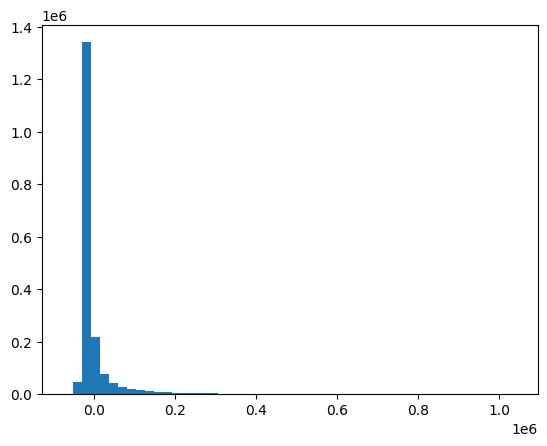

Mean model: RMSE: 60797.1658, MAE: 31890.2193, MAPE: 1.2479
Training % outside of range: 0.809


23/08/30 07:59:34 WARN TaskSetManager: Stage 4 contains a task of very large size (2221 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 49303.0415, MAE: 24532.6115, MAPE: 3869795402697143808.0000


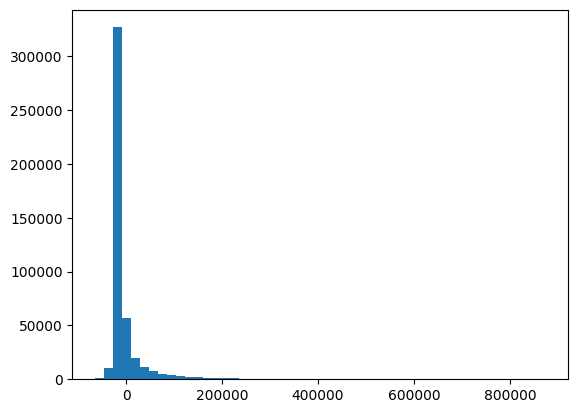

Mean model: RMSE: 56530.4042, MAE: 29779.2238, MAPE: 1.2512
Testing % outside of range: 0.815
Feature importances:
   za: 19.0
   areal_density_overlap_3: 1.0
   slope: 0.0
   n_craters_in_study_region: 0.0
   areal_density: 0.0
   areal_density_overlap_2: 0.0
   center_to_center_nearest_neighbor_distance_mean: 0.0
   center_to_center_nearest_neighbor_distance_stdev: 0.0
   center_to_center_nearest_neighbor_distance_min: 0.0
   center_to_center_nearest_neighbor_distance_max: 0.0
   rim_to_rim_nearest_neighbor_distance_mean: 0.0
   rim_to_rim_nearest_neighbor_distance_stdev: 0.0
   rim_to_rim_nearest_neighbor_distance_max: 0.0


In [12]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.1)
    .setNumIterations(5)
    .setNumLeaves(5)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_5_5 = model

23/08/30 08:00:31 WARN TaskSetManager: Stage 6 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 08:00:32 WARN TaskSetManager: Stage 7 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 08:01:27 WARN TaskSetManager: Stage 8 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 46768.4805, MAE: 20939.5548, MAPE: 2192359518400299008.0000


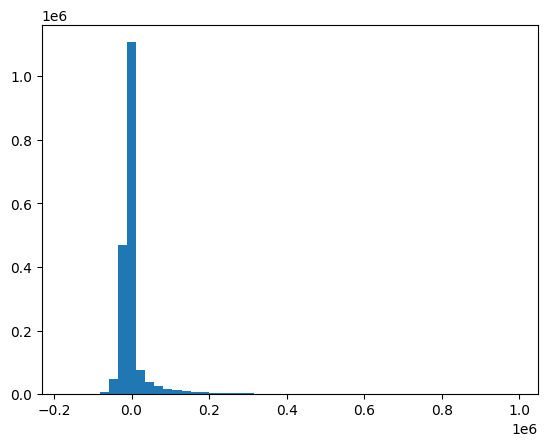

Mean model: RMSE: 60797.1658, MAE: 31890.2193, MAPE: 1.2479
Training % outside of range: 0.831


23/08/30 08:02:07 WARN TaskSetManager: Stage 9 contains a task of very large size (2221 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 44001.3795, MAE: 20148.7063, MAPE: 2194677978649678336.0000


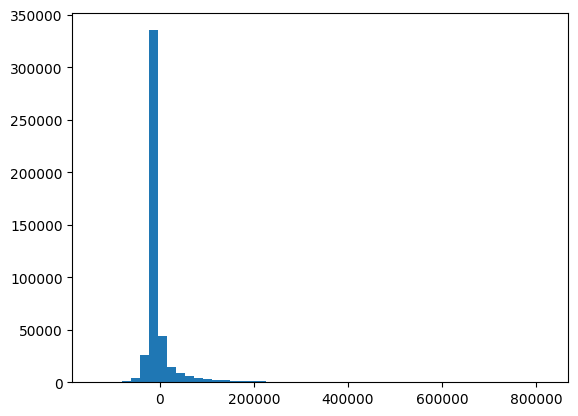

Mean model: RMSE: 56530.4042, MAE: 29779.2238, MAPE: 1.2512
Testing % outside of range: 0.835
Feature importances:
   za: 131.0
   areal_density_overlap_3: 84.0
   rim_to_rim_nearest_neighbor_distance_max: 72.0
   slope: 44.0
   center_to_center_nearest_neighbor_distance_mean: 29.0
   rim_to_rim_nearest_neighbor_distance_mean: 23.0
   n_craters_in_study_region: 20.0
   center_to_center_nearest_neighbor_distance_max: 18.0
   areal_density: 17.0
   center_to_center_nearest_neighbor_distance_min: 15.0
   rim_to_rim_nearest_neighbor_distance_stdev: 14.0
   center_to_center_nearest_neighbor_distance_stdev: 13.0
   areal_density_overlap_2: 10.0


In [13]:
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.1)
    .setNumIterations(10)
    .setNumLeaves(50)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_10_50 = model

23/08/30 08:03:05 WARN TaskSetManager: Stage 11 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 08:03:05 WARN TaskSetManager: Stage 12 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 08:04:00 WARN TaskSetManager: Stage 13 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 45782.3575, MAE: 20475.9812, MAPE: 2137200280957829376.0000


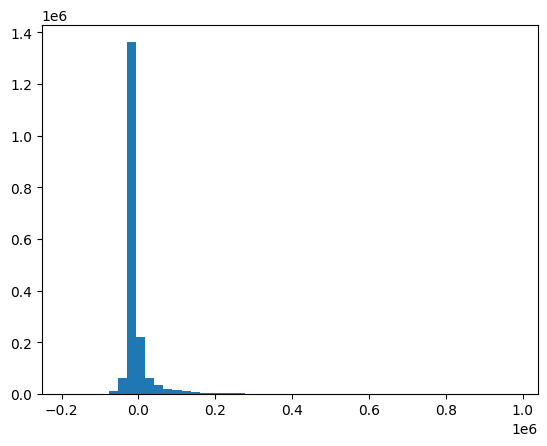

Mean model: RMSE: 60797.1658, MAE: 31890.2193, MAPE: 1.2479
Training % outside of range: 0.834


23/08/30 08:04:40 WARN TaskSetManager: Stage 14 contains a task of very large size (2221 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 43614.5297, MAE: 19934.8554, MAPE: 2139546212981711104.0000


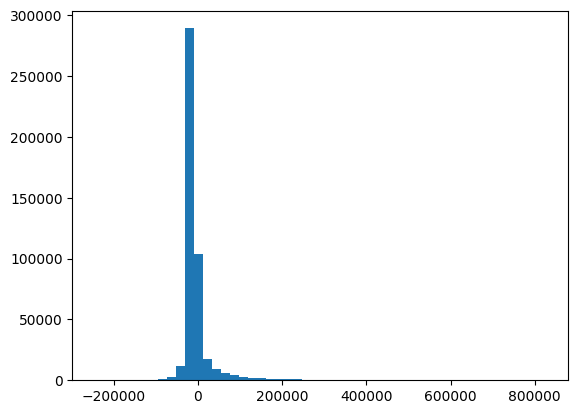

Mean model: RMSE: 56530.4042, MAE: 29779.2238, MAPE: 1.2512
Testing % outside of range: 0.838
Feature importances:
   za: 187.0
   areal_density_overlap_3: 140.0
   slope: 125.0
   rim_to_rim_nearest_neighbor_distance_max: 108.0
   center_to_center_nearest_neighbor_distance_min: 90.0
   center_to_center_nearest_neighbor_distance_mean: 59.0
   rim_to_rim_nearest_neighbor_distance_mean: 54.0
   center_to_center_nearest_neighbor_distance_stdev: 50.0
   areal_density: 43.0
   n_craters_in_study_region: 35.0
   rim_to_rim_nearest_neighbor_distance_stdev: 35.0
   center_to_center_nearest_neighbor_distance_max: 34.0
   areal_density_overlap_2: 30.0


In [14]:
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.1)
    .setNumIterations(10)
    .setNumLeaves(100)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_10_100 = model

23/08/30 08:05:39 WARN TaskSetManager: Stage 16 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 08:05:39 WARN TaskSetManager: Stage 17 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 08:06:34 WARN TaskSetManager: Stage 18 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 41261.6748, MAE: 16865.9588, MAPE: 177055893644408192.0000


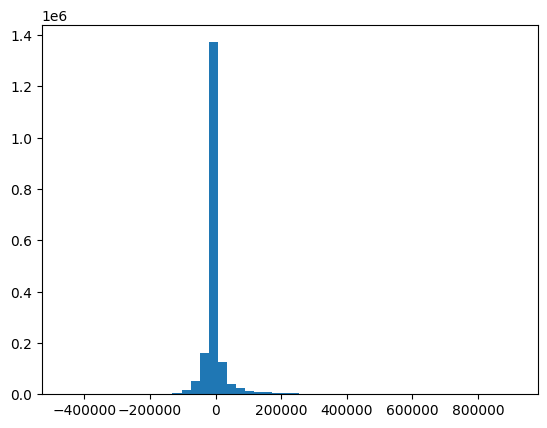

Mean model: RMSE: 60797.1658, MAE: 31890.2193, MAPE: 1.2479
Training % outside of range: 0.771


23/08/30 08:07:16 WARN TaskSetManager: Stage 19 contains a task of very large size (2221 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 41530.9056, MAE: 16701.0780, MAPE: 178603752182813248.0000


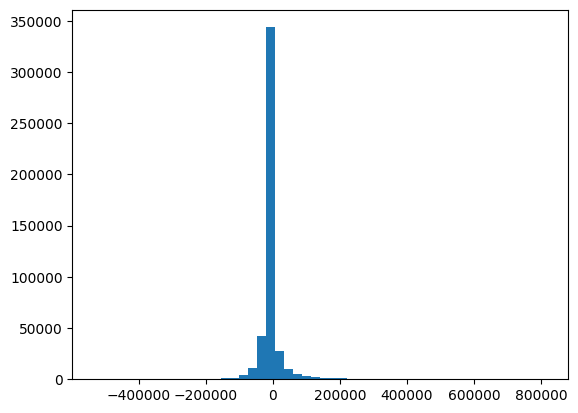

Mean model: RMSE: 56530.4042, MAE: 29779.2238, MAPE: 1.2512
Testing % outside of range: 0.770
Feature importances:
   slope: 417.0
   za: 386.0
   center_to_center_nearest_neighbor_distance_min: 302.0
   areal_density_overlap_3: 271.0
   rim_to_rim_nearest_neighbor_distance_max: 181.0
   rim_to_rim_nearest_neighbor_distance_mean: 153.0
   center_to_center_nearest_neighbor_distance_mean: 151.0
   areal_density: 117.0
   center_to_center_nearest_neighbor_distance_stdev: 115.0
   center_to_center_nearest_neighbor_distance_max: 103.0
   n_craters_in_study_region: 97.0
   areal_density_overlap_2: 93.0
   rim_to_rim_nearest_neighbor_distance_stdev: 64.0


In [15]:
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.1)
    .setNumIterations(50)
    .setNumLeaves(50)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_50_50 = model

23/08/30 08:08:15 WARN TaskSetManager: Stage 21 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 08:08:15 WARN TaskSetManager: Stage 22 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 08:09:11 WARN TaskSetManager: Stage 23 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 42825.1035, MAE: 16536.2427, MAPE: 304384812259319040.0000


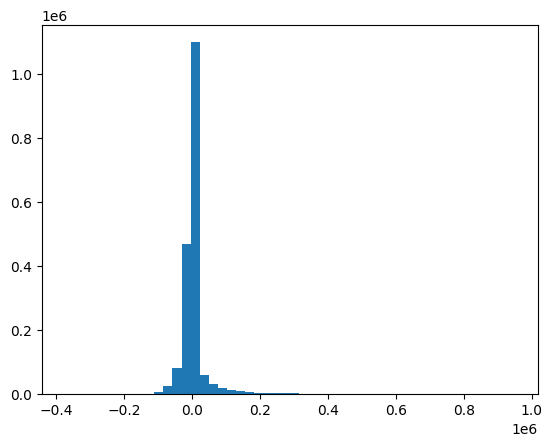

Mean model: RMSE: 60797.1658, MAE: 31890.2193, MAPE: 1.2479
Training % outside of range: 0.777


23/08/30 08:09:52 WARN TaskSetManager: Stage 24 contains a task of very large size (2221 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 41504.5874, MAE: 16019.4532, MAPE: 305248646318196160.0000


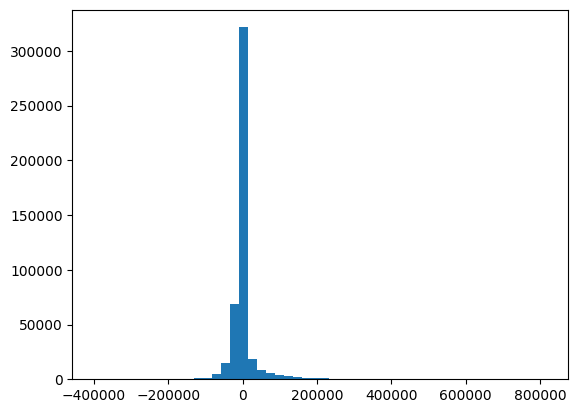

Mean model: RMSE: 56530.4042, MAE: 29779.2238, MAPE: 1.2512
Testing % outside of range: 0.777
Feature importances:
   za: 461.0
   slope: 375.0
   areal_density_overlap_3: 315.0
   center_to_center_nearest_neighbor_distance_min: 237.0
   rim_to_rim_nearest_neighbor_distance_max: 235.0
   center_to_center_nearest_neighbor_distance_mean: 148.0
   rim_to_rim_nearest_neighbor_distance_mean: 143.0
   center_to_center_nearest_neighbor_distance_max: 118.0
   areal_density: 107.0
   center_to_center_nearest_neighbor_distance_stdev: 91.0
   n_craters_in_study_region: 87.0
   rim_to_rim_nearest_neighbor_distance_stdev: 71.0
   areal_density_overlap_2: 62.0


In [16]:
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setBoostingType("dart")
    .setLearningRate(0.1)
    .setNumIterations(50)
    .setNumLeaves(50)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_50_50_dart = model

23/08/30 08:10:53 WARN TaskSetManager: Stage 26 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 08:10:53 WARN TaskSetManager: Stage 27 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 08:11:55 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
23/08/30 08:11:55 WARN TaskSetManager: Stage 28 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 31482.2738, MAE: 12801.8961, MAPE: 75621172427612544.0000


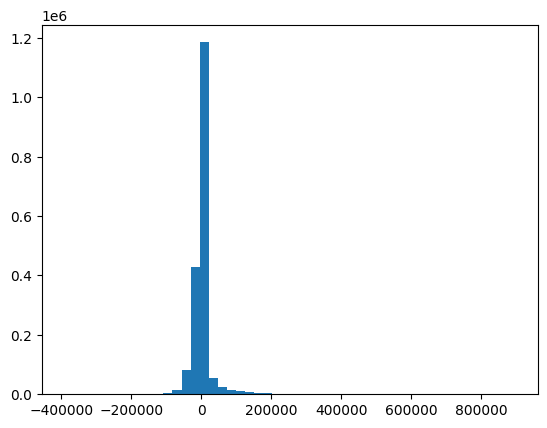

Mean model: RMSE: 60797.1658, MAE: 31890.2193, MAPE: 1.2479
Training % outside of range: 0.764


23/08/30 08:12:38 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
23/08/30 08:12:38 WARN TaskSetManager: Stage 29 contains a task of very large size (2221 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 44380.6487, MAE: 17391.4803, MAPE: 77690891203148432.0000


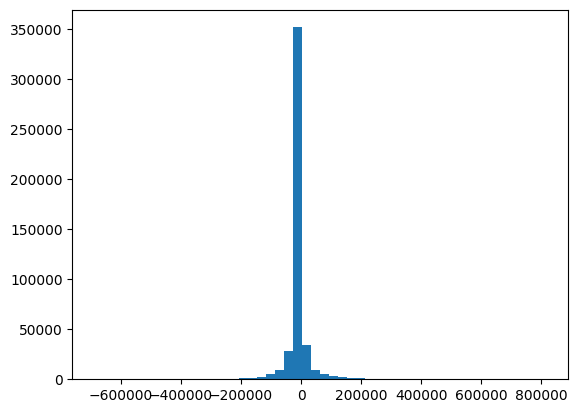

Mean model: RMSE: 56530.4042, MAE: 29779.2238, MAPE: 1.2512
Testing % outside of range: 0.769
Feature importances:
   center_to_center_nearest_neighbor_distance_min: 11009.0
   slope: 9847.0
   areal_density_overlap_3: 3677.0
   rim_to_rim_nearest_neighbor_distance_mean: 3254.0
   areal_density: 3127.0
   center_to_center_nearest_neighbor_distance_stdev: 3029.0
   za: 2934.0
   center_to_center_nearest_neighbor_distance_mean: 2747.0
   rim_to_rim_nearest_neighbor_distance_max: 2596.0
   areal_density_overlap_2: 2518.0
   n_craters_in_study_region: 2498.0
   rim_to_rim_nearest_neighbor_distance_stdev: 1575.0
   center_to_center_nearest_neighbor_distance_max: 1089.0


In [17]:
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.05)
    .setNumIterations(100)
    .setNumLeaves(500)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_100_500 = model

23/08/30 08:13:38 WARN TaskSetManager: Stage 31 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 08:13:38 WARN TaskSetManager: Stage 32 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 08:14:39 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/08/30 08:14:39 WARN TaskSetManager: Stage 33 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 32183.2453, MAE: 13502.3787, MAPE: 499590314875508608.0000


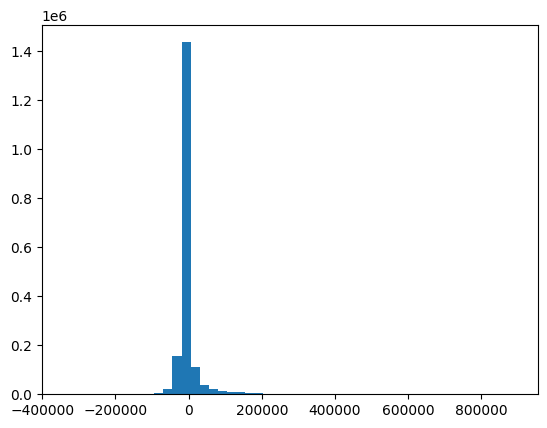

Mean model: RMSE: 60797.1658, MAE: 31890.2193, MAPE: 1.2479
Training % outside of range: 0.829


23/08/30 08:15:21 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/08/30 08:15:21 WARN TaskSetManager: Stage 34 contains a task of very large size (2221 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 43767.4996, MAE: 17676.2208, MAPE: 500882917831730112.0000


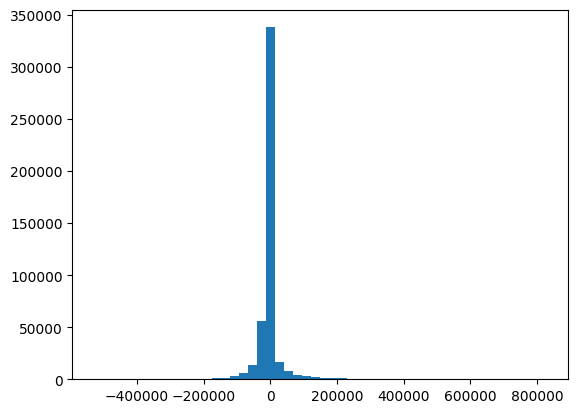

Mean model: RMSE: 56530.4042, MAE: 29779.2238, MAPE: 1.2512
Testing % outside of range: 0.833
Feature importances:
   center_to_center_nearest_neighbor_distance_min: 11336.0
   slope: 9702.0
   areal_density_overlap_3: 3751.0
   rim_to_rim_nearest_neighbor_distance_mean: 3134.0
   center_to_center_nearest_neighbor_distance_stdev: 3023.0
   areal_density: 2989.0
   rim_to_rim_nearest_neighbor_distance_max: 2897.0
   za: 2783.0
   center_to_center_nearest_neighbor_distance_mean: 2712.0
   areal_density_overlap_2: 2591.0
   n_craters_in_study_region: 2196.0
   rim_to_rim_nearest_neighbor_distance_stdev: 1607.0
   center_to_center_nearest_neighbor_distance_max: 1229.0


In [18]:
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.05)
    .setNumIterations(50)
    .setNumLeaves(1000)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_50_1000 = model

23/08/30 08:16:20 WARN TaskSetManager: Stage 36 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 08:16:20 WARN TaskSetManager: Stage 37 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 08:17:46 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/08/30 08:17:47 WARN TaskSetManager: Stage 38 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 21265.5801, MAE: 8371.2052, MAPE: 33203253680993076.0000


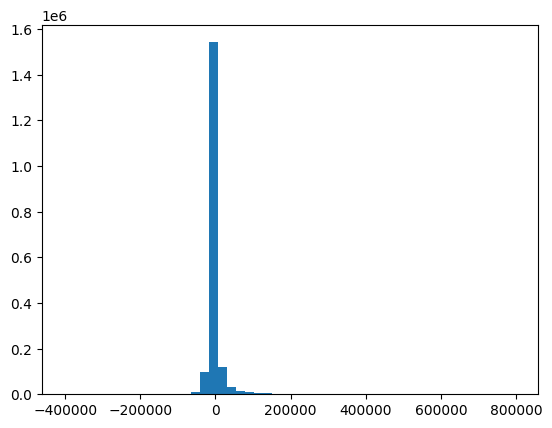

Mean model: RMSE: 60797.1658, MAE: 31890.2193, MAPE: 1.2479
Training % outside of range: 0.668


23/08/30 08:18:32 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/08/30 08:18:32 WARN TaskSetManager: Stage 39 contains a task of very large size (2221 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 48782.6722, MAE: 19424.2131, MAPE: 34104179590474720.0000


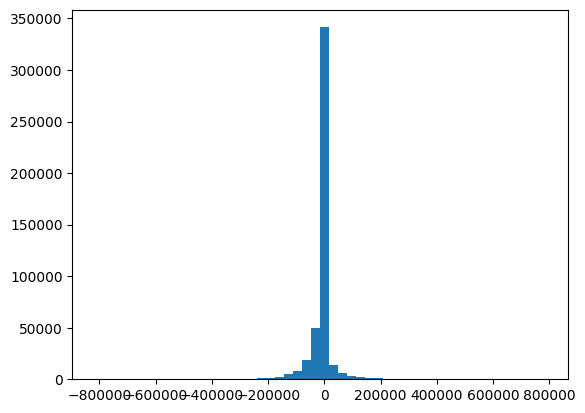

Mean model: RMSE: 56530.4042, MAE: 29779.2238, MAPE: 1.2512
Testing % outside of range: 0.696
Feature importances:
   center_to_center_nearest_neighbor_distance_min: 51812.0
   slope: 40891.0
   areal_density_overlap_3: 19050.0
   areal_density: 18075.0
   rim_to_rim_nearest_neighbor_distance_max: 17369.0
   areal_density_overlap_2: 14840.0
   rim_to_rim_nearest_neighbor_distance_mean: 14506.0
   center_to_center_nearest_neighbor_distance_mean: 13887.0
   center_to_center_nearest_neighbor_distance_stdev: 13390.0
   za: 12876.0
   n_craters_in_study_region: 11795.0
   center_to_center_nearest_neighbor_distance_max: 11646.0
   rim_to_rim_nearest_neighbor_distance_stdev: 9363.0


In [19]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.05)
    .setNumIterations(500)
    .setNumLeaves(500)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_500_500 = model

23/08/30 08:19:32 WARN TaskSetManager: Stage 41 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 08:19:32 WARN TaskSetManager: Stage 42 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 08:20:29 WARN TaskSetManager: Stage 43 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 48366.9122, MAE: 14852.9783, MAPE: 5991203732701943.0000


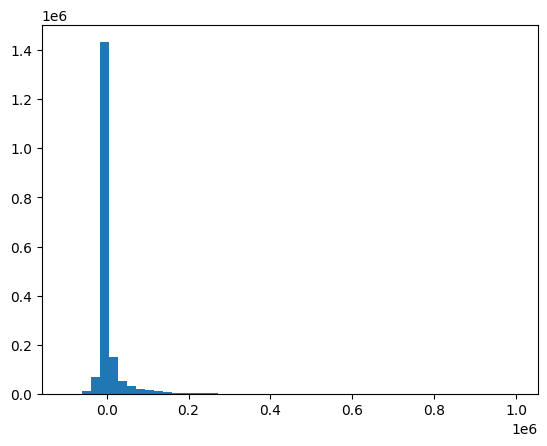

Mean model: RMSE: 60797.1658, MAE: 31890.2193, MAPE: 1.2479
Training % outside of range: 0.564


23/08/30 08:21:12 WARN TaskSetManager: Stage 44 contains a task of very large size (2221 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 45343.6132, MAE: 14105.9286, MAPE: 6056639005634528.0000


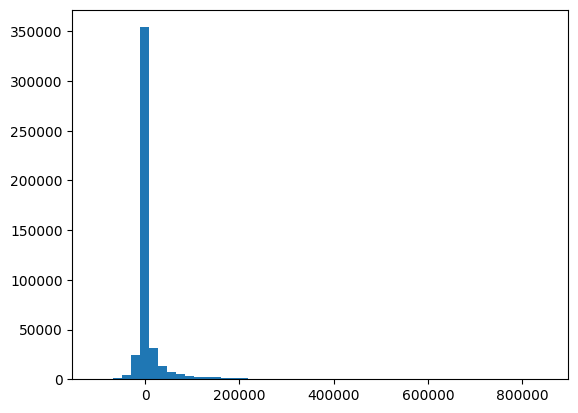

Mean model: RMSE: 56530.4042, MAE: 29779.2238, MAPE: 1.2512
Testing % outside of range: 0.558
Feature importances:
   za: 874.0
   rim_to_rim_nearest_neighbor_distance_mean: 603.0
   slope: 591.0
   areal_density_overlap_3: 574.0
   rim_to_rim_nearest_neighbor_distance_max: 439.0
   center_to_center_nearest_neighbor_distance_stdev: 341.0
   areal_density: 323.0
   center_to_center_nearest_neighbor_distance_mean: 285.0
   areal_density_overlap_2: 261.0
   center_to_center_nearest_neighbor_distance_max: 210.0
   rim_to_rim_nearest_neighbor_distance_stdev: 187.0
   n_craters_in_study_region: 133.0
   center_to_center_nearest_neighbor_distance_min: 129.0


In [20]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    .setObjective('quantile')
     # .setObjective('regression')
    .setLabelCol(metric)
    .setAlpha(0.5)
    .setLearningRate(0.1)
    .setNumIterations(50)
    .setNumLeaves(100)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_50_100_median = model

In [21]:
# # Small model first
# poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
# X_train = poly_transform.fit_transform(train_df[ivs])
# X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

# train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

# assembler = VectorAssembler(
#     inputCols=list(X_train.columns),
#     outputCol="features")

# train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

# model = (LightGBMRegressor()
#     .setObjective('quantile')
#      # .setObjective('regression')
#     .setLabelCol(metric)
#     .setAlpha(0.5)
#     .setLearningRate(0.1)
#     .setNumIterations(50)
#     .setNumLeaves(100)
#     .setNumThreads(n_cores)
#     .fit(train_df_featurized))

# # Metrics for all train data
# pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
# pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
# print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# # Metrics for all test data
# pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
# pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
# pred_df.outside_range.mean()
# print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

# importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
# print(f"Feature importances:")
# for x in importances:
#     print(f"   {x[0]}: {x[1]}")

# model_reg_50_100_median_degree_2 = model

23/08/30 08:26:57 WARN TaskSetManager: Stage 46 contains a task of very large size (70669 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 08:26:58 WARN TaskSetManager: Stage 47 contains a task of very large size (70669 KiB). The maximum recommended task size is 1000 KiB.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


23/08/30 08:32:57 WARN TaskSetManager: Stage 48 contains a task of very large size (70669 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 08:33:10 ERROR TaskSetManager: Total size of serialized results of 18 tasks (1033.3 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
23/08/30 08:33:10 WARN TaskSetManager: Lost task 11.0 in stage 48.0 (TID 933) (muninn.lan executor driver): TaskKilled (Tasks result size has exceeded maxResultSize)
23/08/30 08:33:10 ERROR TaskSetManager: Total size of serialized results of 19 tasks (1090.4 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
23/08/30 08:33:10 WARN TaskSetManager: Lost task 15.0 in stage 48.0 (TID 937) (muninn.lan executor driver): TaskKilled (Tasks result size has exceeded maxResultSize)
23/08/30 08:33:10 ERROR TaskSetManager: Total size of serialized results of 20 tasks (1147.8 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
23/08/30 08:33:10 WARN TaskSetManager: Lost task 21.0 in stage 48.

Py4JJavaError: An error occurred while calling o5054.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Total size of serialized results of 18 tasks (1033.3 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2328)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1019)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1018)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3997)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4167)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:526)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4165)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:118)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:195)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:103)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:827)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4165)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3994)
	at jdk.internal.reflect.GeneratedMethodAccessor254.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


In [ ]:
# # Small model first
# poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
# X_train = poly_transform.fit_transform(train_df[ivs])
# X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

# train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

# assembler = VectorAssembler(
#     inputCols=list(X_train.columns),
#     outputCol="features")

# train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

# model = (LightGBMRegressor()
#     .setObjective('quantile')
#      # .setObjective('regression')
#     .setLabelCol(metric)
#     .setAlpha(0.5)
#     .setLearningRate(0.05)
#     .setNumIterations(50)
#     .setNumLeaves(1000)
#     .setNumThreads(n_cores)
#     .fit(train_df_featurized))

# # Metrics for all train data
# pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
# pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
# print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# # Metrics for all test data
# pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
# pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
# pred_df.outside_range.mean()
# print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

# importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
# print(f"Feature importances:")
# for x in importances:
#     print(f"   {x[0]}: {x[1]}")

# model_reg_50_1000_median_degree_2 = model

In [ ]:
# Best: Test ~11.5% RMSE, 8% MAE
# Best including eff radius, min rim perc: ~10% RMSE, 6.5% MAE
# With log-transformed IVs:

### Plot Predictions

23/08/30 08:43:06 WARN TaskSetManager: Stage 50 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 08:43:06 WARN TaskSetManager: Stage 51 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 08:44:11 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/08/30 08:44:11 WARN TaskSetManager: Stage 52 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 46238.6052, MAE: 13323.6237, MAPE: 6400288228219143.0000


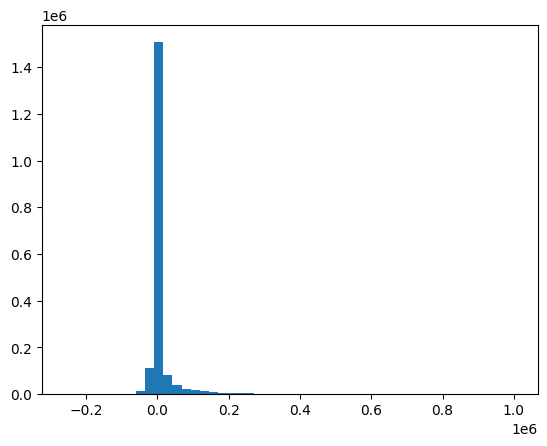

Mean model: RMSE: 60797.1658, MAE: 31890.2193, MAPE: 1.2479
Training % outside of range: 0.573


23/08/30 08:44:56 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/08/30 08:44:56 WARN TaskSetManager: Stage 53 contains a task of very large size (2221 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 43996.4636, MAE: 13596.5939, MAPE: 6456765453530042.0000


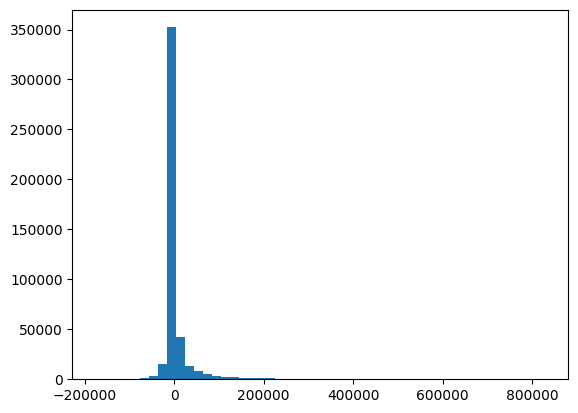

Mean model: RMSE: 56530.4042, MAE: 29779.2238, MAPE: 1.2512
Testing % outside of range: 0.581
Feature importances:
   slope: 8928.0
   center_to_center_nearest_neighbor_distance_min: 5483.0
   za: 4603.0
   center_to_center_nearest_neighbor_distance_stdev: 4268.0
   areal_density_overlap_3: 4238.0
   rim_to_rim_nearest_neighbor_distance_mean: 3784.0
   rim_to_rim_nearest_neighbor_distance_stdev: 3231.0
   rim_to_rim_nearest_neighbor_distance_max: 3088.0
   areal_density_overlap_2: 2962.0
   center_to_center_nearest_neighbor_distance_mean: 2955.0
   areal_density: 2949.0
   n_craters_in_study_region: 2846.0
   center_to_center_nearest_neighbor_distance_max: 1765.0


In [22]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    .setObjective('quantile')
     # .setObjective('regression')
    .setLabelCol(metric)
    .setLambdaL2(0.05)
    .setAlpha(0.5)
    .setLearningRate(0.05)
    .setNumIterations(100)
    .setNumLeaves(512)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

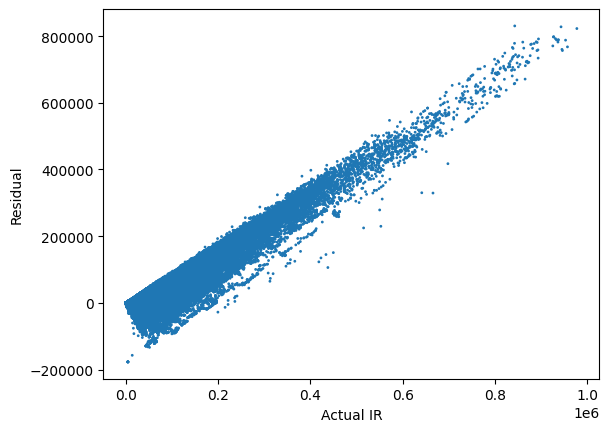

In [23]:
plt.scatter(pred_df[metric], pred_df[metric] - pred_df.prediction, sizes=[1] * pred_df.shape[0])
plt.xlabel("Actual IR")
plt.ylabel("Residual")
plt.show()

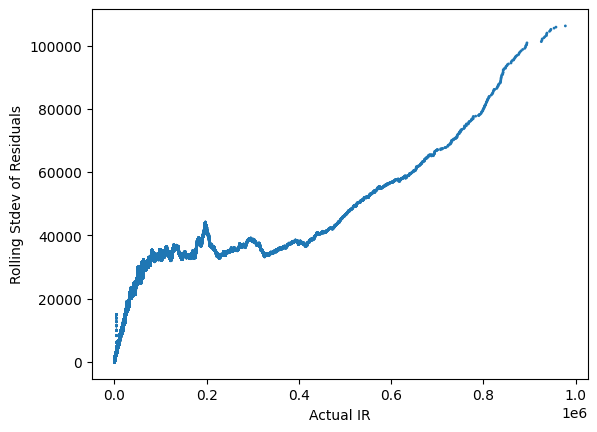

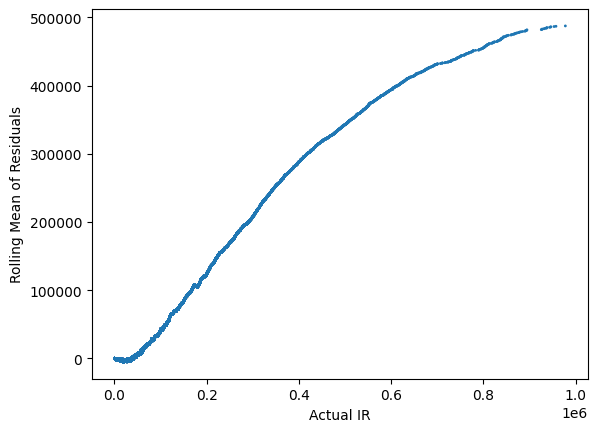

In [24]:
pred_sorted = pred_df.sort_values(metric)
plt.scatter(pred_sorted[metric], (pred_sorted[metric] - pred_sorted.prediction).rolling(1000).std(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Actual IR")
plt.ylabel("Rolling Stdev of Residuals")
plt.show()

plt.scatter(pred_sorted[metric], (pred_sorted[metric] - pred_sorted.prediction).rolling(1000).mean(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Actual IR")
plt.ylabel("Rolling Mean of Residuals")
plt.show()

23/08/30 08:46:02 WARN TaskSetManager: Stage 55 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 08:46:02 WARN TaskSetManager: Stage 56 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 08:47:03 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/08/30 08:47:03 WARN TaskSetManager: Stage 57 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 47925.0097, MAE: 14070.1907, MAPE: 80918484461242112.0000


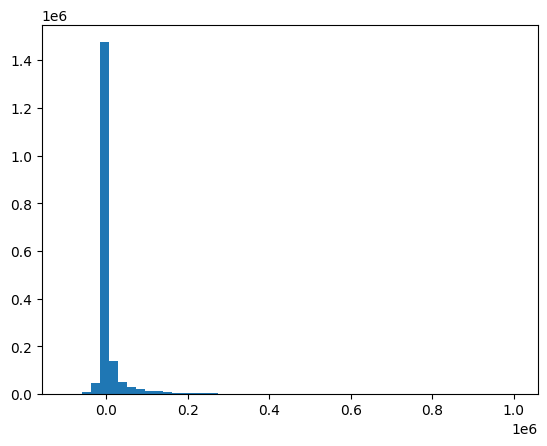

Mean model: RMSE: 60797.1658, MAE: 31890.2193, MAPE: 1.2479
Training % outside of range: 0.638


23/08/30 08:47:46 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/08/30 08:47:46 WARN TaskSetManager: Stage 58 contains a task of very large size (2221 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 45187.9463, MAE: 13876.1780, MAPE: 81086015180775872.0000


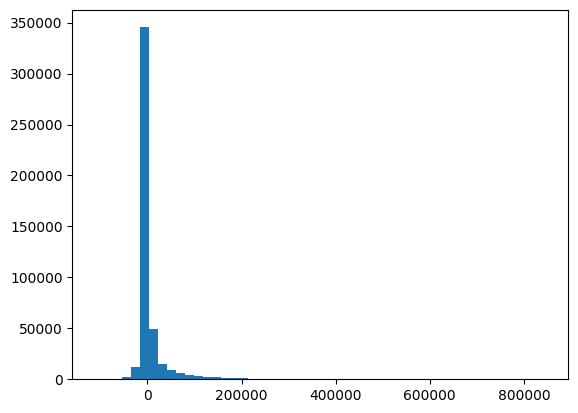

Mean model: RMSE: 56530.4042, MAE: 29779.2238, MAPE: 1.2512
Testing % outside of range: 0.636
Feature importances:
   slope: 4457.0
   za: 2900.0
   areal_density_overlap_3: 2617.0
   center_to_center_nearest_neighbor_distance_stdev: 2322.0
   rim_to_rim_nearest_neighbor_distance_mean: 2257.0
   center_to_center_nearest_neighbor_distance_min: 1978.0
   center_to_center_nearest_neighbor_distance_mean: 1801.0
   rim_to_rim_nearest_neighbor_distance_max: 1651.0
   rim_to_rim_nearest_neighbor_distance_stdev: 1411.0
   areal_density_overlap_2: 1367.0
   n_craters_in_study_region: 1254.0
   areal_density: 1057.0
   center_to_center_nearest_neighbor_distance_max: 478.0


In [25]:
# Model for IR threshold

threshold = 0.0
xtr = train_df[train_df.information_remaining > threshold].reset_index().copy()
xte = test_df[test_df.information_remaining > threshold].reset_index().copy()

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(xtr[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([xtr[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    .setObjective('quantile')
     # .setObjective('regression')
    .setLabelCol(metric)
    .setLambdaL2(0.05)
    .setAlpha(0.5)
    .setLearningRate(0.05)
    .setNumIterations(50)
    .setNumLeaves(512)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, xtr, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, xte, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

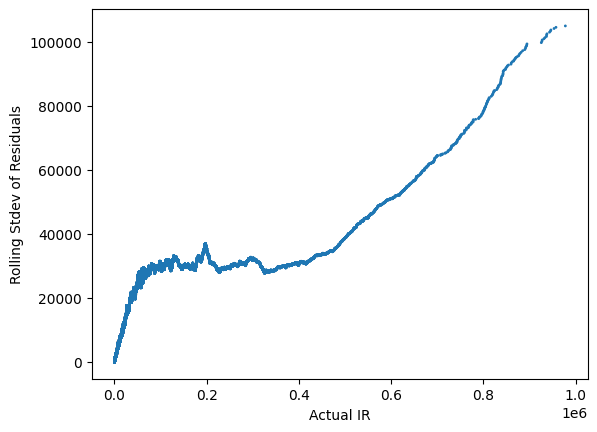

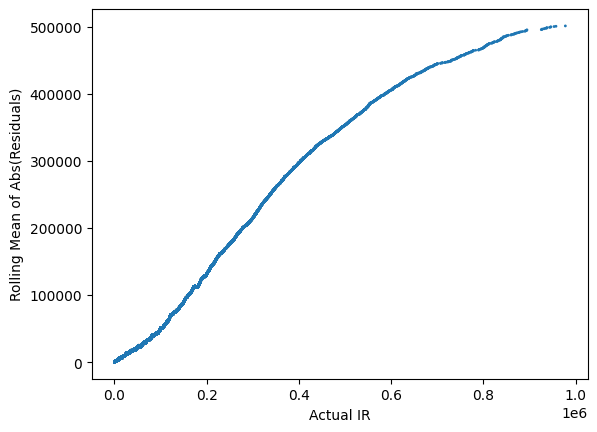

In [26]:
pred_sorted = pred_df.sort_values(metric)
plt.scatter(pred_sorted[metric], (pred_sorted[metric] - pred_sorted.prediction).rolling(1000).std(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Actual NR")
plt.ylabel("Rolling Stdev of Residuals")
plt.show()

plt.scatter(pred_sorted[metric], (pred_sorted[metric] - pred_sorted.prediction).abs().rolling(1000).mean(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Actual NR")
plt.ylabel("Rolling Mean of Abs(Residuals)")
plt.show()

### Plots of 95% CI

In [27]:
min_data_in_leaf = 500
learning_rate = 0.05
n_iterations = 300
n_leaves = 512
boosting_type = "dart"

threshold = 0.0
xtr = train_df[train_df.information_remaining > threshold].reset_index().copy()
xte = test_df[test_df.information_remaining > threshold].reset_index().copy()

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(xtr[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([xtr[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setBoostingType(boosting_type)
    .setAlpha(0.1)
    .setLearningRate(learning_rate)
    .setNumIterations(n_iterations)
    .setNumLeaves(n_leaves)
    .setMinDataInLeaf(min_data_in_leaf)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

model_10_quantile = model

23/08/30 08:48:51 WARN TaskSetManager: Stage 60 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 08:48:51 WARN TaskSetManager: Stage 61 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.


In [28]:
model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setBoostingType(boosting_type)
    .setAlpha(0.50)
    .setLearningRate(learning_rate)
    .setNumIterations(n_iterations)
    .setNumLeaves(n_leaves)
    .setMinDataInLeaf(min_data_in_leaf)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

model_50_quantile = model

23/08/30 08:49:50 WARN TaskSetManager: Stage 63 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 08:49:50 WARN TaskSetManager: Stage 64 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.


In [29]:
model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setBoostingType(boosting_type)
    .setAlpha(0.90)
    .setLearningRate(learning_rate)
    .setNumIterations(n_iterations)
    .setNumLeaves(n_leaves)
    .setMinDataInLeaf(min_data_in_leaf)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

model_90_quantile = model

23/08/30 08:50:49 WARN TaskSetManager: Stage 66 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.
23/08/30 08:50:49 WARN TaskSetManager: Stage 67 contains a task of very large size (9236 KiB). The maximum recommended task size is 1000 KiB.


23/08/30 08:51:56 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
23/08/30 08:51:56 WARN TaskSetManager: Stage 68 contains a task of very large size (2221 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 54195.1083, MAE: 18003.1227, MAPE: 37341643217768.7266


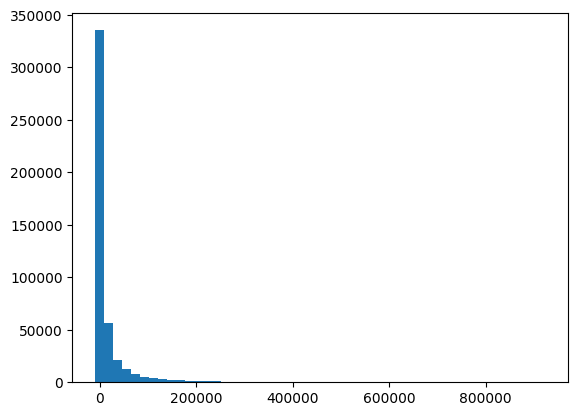

Mean model: RMSE: 56530.4042, MAE: 29779.2238, MAPE: 1.2512


23/08/30 08:52:18 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB
23/08/30 08:52:18 WARN TaskSetManager: Stage 69 contains a task of very large size (2221 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 45490.5884, MAE: 13749.7393, MAPE: 2429395902808312.0000


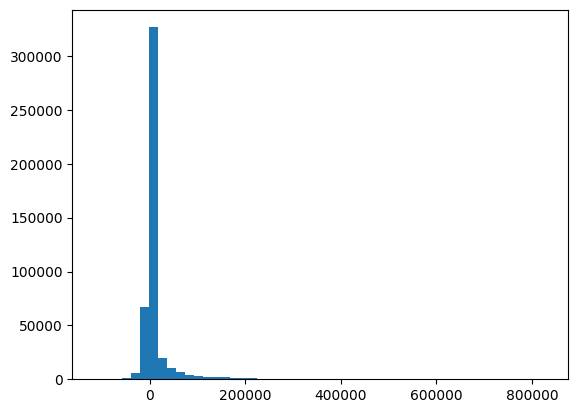

Mean model: RMSE: 56530.4042, MAE: 29779.2238, MAPE: 1.2512


23/08/30 08:52:42 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB
23/08/30 08:52:42 WARN TaskSetManager: Stage 70 contains a task of very large size (2221 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 59160.2596, MAE: 28373.0500, MAPE: 50506653521134664.0000


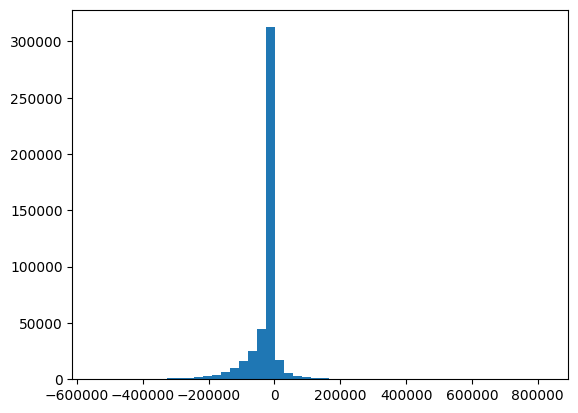

Mean model: RMSE: 56530.4042, MAE: 29779.2238, MAPE: 1.2512


In [30]:
pred_df_10_quantile = score_model(model_10_quantile, xte, metric, assembler, ivs, list(X_train.columns))
pred_df_50_quantile = score_model(model_50_quantile, xte, metric, assembler, ivs, list(X_train.columns))
pred_df_90_quantile = score_model(model_90_quantile, xte, metric, assembler, ivs, list(X_train.columns))

In [31]:
pred_df = pred_df_10_quantile.copy()
pred_df["prediction_10_quantile"] = pred_df["prediction"]
pred_df["prediction_50_quantile"] = pred_df_50_quantile["prediction"]
pred_df["prediction_90_quantile"] = pred_df_90_quantile["prediction"]
pred_df["slope"] = test_df["slope"]
pred_df["effective_radius_multiplier"] = test_df["effective_radius_multiplier"]
pred_df["min_rim_percentage"] = test_df["min_rim_percentage"]

slope                          2.444887
effective_radius_multiplier    1.282611
min_rim_percentage             0.430894
Name: 0, dtype: object


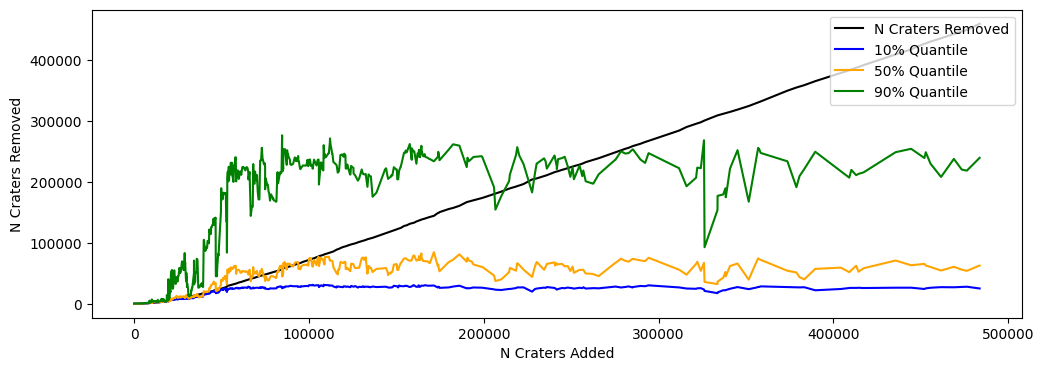

slope                          1.465672
effective_radius_multiplier    1.484714
min_rim_percentage             0.625771
Name: 50, dtype: object


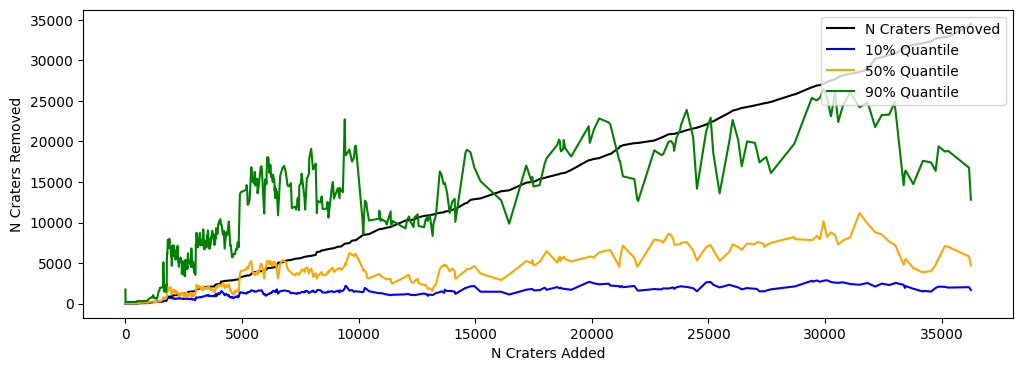

slope                          2.805113
effective_radius_multiplier    1.884478
min_rim_percentage             0.250041
Name: 100, dtype: object


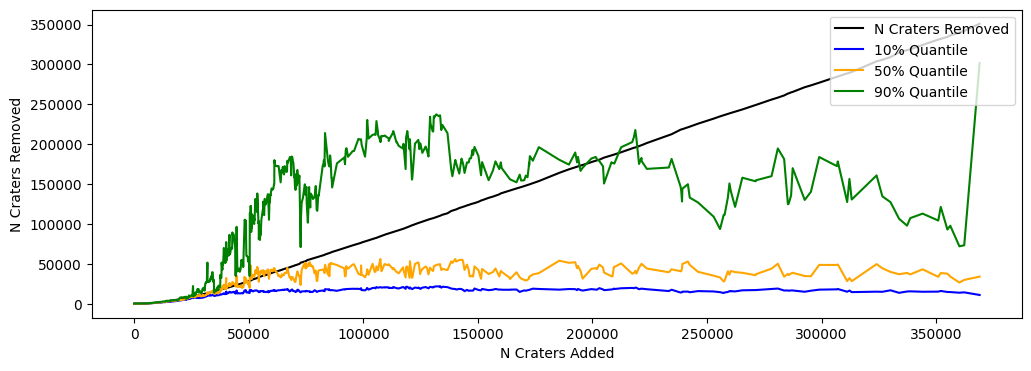

slope                          1.607999
effective_radius_multiplier    1.723657
min_rim_percentage             0.670446
Name: 150, dtype: object


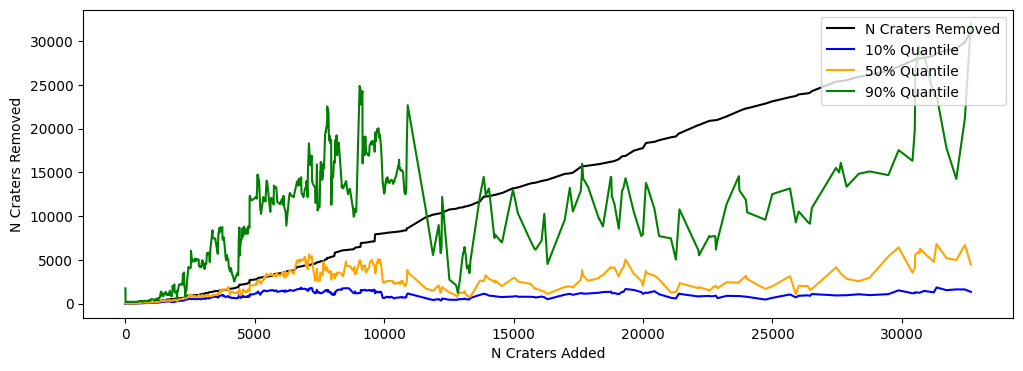

slope                          1.907369
effective_radius_multiplier    1.641525
min_rim_percentage             0.304169
Name: 200, dtype: object


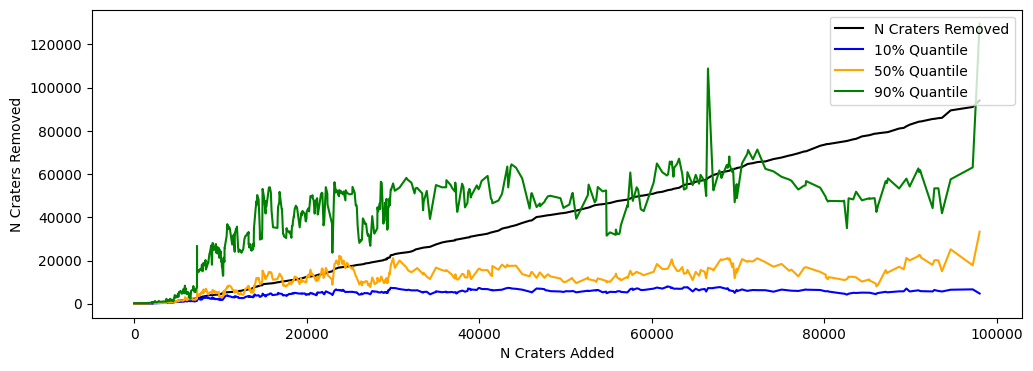

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 41036)
Traceback (most recent call last):
  File "/usr/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  File "/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pyspark/accumulators.py", line 253, in poll
    if func():
       ^^^^^^
  File "/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pyspark/

In [35]:
simulation_ids = list(pred_df.simulation_id.unique())

for x in simulation_ids[:5]:
    df = pred_df[pred_df.simulation_id == x].copy()
    print(df.iloc[0][["slope", "effective_radius_multiplier", "min_rim_percentage"]])
    df = df.sort_values("n_craters_added_in_study_region")
    
    fig = plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(111)
    
    plt1 = ax1.plot(df.n_craters_added_in_study_region, df[metric], color='black', label="N Craters Removed")
    plt2 = ax1.plot(df.n_craters_added_in_study_region, df["prediction_10_quantile"], color='blue', label="10% Quantile")
    plt3 = ax1.plot(df.n_craters_added_in_study_region, df["prediction_50_quantile"], color='orange', label="50% Quantile")
    plt4 = ax1.plot(df.n_craters_added_in_study_region, df["prediction_90_quantile"], color='green', label="90% Quantile")
    ax1.set_xlabel("N Craters Added")
    ax1.set_ylabel("N Craters Removed")
    
    lns = plt1 + plt2 + plt3 + plt4
    ax1.legend(lns, [l.get_label() for l in lns], loc=1)
    
    plt.show()

In [ ]:
pred_df["ci_width"] = pred_df["prediction_90_quantile"] - pred_df["prediction_10_quantile"]

pred_sorted = pred_df.sort_values(metric)
plt.scatter(pred_sorted[metric], pred_sorted["ci_width"].rolling(1000).mean(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("IR")
plt.ylabel("Rolling Mean CI Width")
plt.show()

In [ ]:
pred_df["ci_width"] = pred_df["prediction_90_quantile"] - pred_df["prediction_10_quantile"]

pred_sorted = pred_df.sort_values(metric)
plt.scatter(pred_sorted[metric], pred_sorted["ci_width"].rolling(1000).std(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("IR")
plt.ylabel("Rolling Stdev CI Width")
plt.show()

In [ ]:
pred_sorted = pred_df.sort_values("slope")
resid = (pred_sorted["prediction_50_quantile"] - pred_sorted[metric])

plt.scatter(pred_sorted["slope"], resid.rolling(1000).mean(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Slope")
plt.ylabel("Residual")
plt.show()

In [ ]:
pred_sorted = pred_df.sort_values("effective_radius_multiplier")
resid = (pred_sorted["prediction_50_quantile"] - pred_sorted[metric])

plt.scatter(pred_sorted["effective_radius_multiplier"], resid.rolling(1000).mean(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Eff Rad Mult")
plt.ylabel("Residual")
plt.show()

In [ ]:
pred_sorted = pred_df.sort_values("min_rim_percentage")
resid = (pred_sorted["prediction_50_quantile"] - pred_sorted[metric])

plt.scatter(pred_sorted["min_rim_percentage"], resid.rolling(1000).mean(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Min Rim Percentage")
plt.ylabel("Residual")
plt.show()